**Predicting Pulmonary Edema for Myocardial Infarction Patients**
-
**Roshan S. Parikh**

This is the code file for the project that includes all steps of the ML pipeline except for EDA, which can also be found in the GitHub repository for this project.

In [304]:
import pandas as pd

import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import math
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

**LOADING DATA**

In [305]:
'''
Loading the data from UCI repository.
''' 

from ucimlrepo import fetch_ucirepo 
pd.set_option('display.max_rows', None)
  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
df = myocardial_infarction_complications.data.original 
X_full = myocardial_infarction_complications.data.features[:] 
y_full = myocardial_infarction_complications.data.targets[:] 
  
# metadata 
metadata = myocardial_infarction_complications.metadata
  
# variable information 
vars = myocardial_infarction_complications.variables

In [424]:
''' 
Reconfigure data for our purpose.
- Make X feature matrix
- Pick target variable to be Pulmonary Edema (OTEK_LANC)
'''
X = X_full[:]
y = y_full['OTEK_LANC']

**MISSING VALUES**

In [425]:
pd.set_option('display.max_rows', 10)  # or use a specific number

X_nan_number = X.isna().sum().sort_values(ascending=False)
X_nan_percentage = X_nan_number/1700

print(X_nan_percentage>0.5)

missing_rows = X[X.isnull()]
print(missing_rows.shape) # Every row has at least one missing value

KFK_BLOOD      True
IBS_NASL       True
D_AD_KBRIG     True
S_AD_KBRIG     True
NOT_NA_KB     False
              ...  
zab_leg_04    False
NA_R_1_n      False
INF_ANAM      False
IM_PG_P       False
SEX           False
Length: 111, dtype: bool
(1700, 111)


In [426]:
'''
Dropping columns with >50% NaNs.
'''
X = X.drop(['KFK_BLOOD', 'IBS_NASL', 'D_AD_KBRIG', 'S_AD_KBRIG'], axis=1)

In [427]:
''' 
Dropping rows where 'AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'L_BLOOD', 'NA_BLOOD', 'K_BLOOD' are NaN.
'''

for ftr in ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'L_BLOOD', 'NA_BLOOD', 'K_BLOOD']:
    valid_index = X[X[ftr].notna()].index
    X = X.loc[valid_index]
    y = y.loc[valid_index]

**CLEANING DATA**

In [428]:
''' 
Cleaning data
- Organize features for later use.
- Four types provided in dataset information: binary, categorical, integer, continuous
'''
names_binary_feats = np.array(vars[(vars['type']=='Binary') & (vars['role']=='Feature')].name)
names_cat_feats = np.array(vars[(vars['type']=='Categorical') & (vars['role']=='Feature')].name)
names_int_feats = np.array(vars[(vars['type']=='Integer') & (vars['role']=='Feature')].name)
names_cont_feats = np.array(vars[(vars['type']=='Continuous') & (vars['role']=='Feature')].name)

# Adjusting for already-removed columns
names_cont_feats = np.setdiff1d(names_cont_feats, ['KFK_BLOOD'])
names_binary_feats = np.setdiff1d(names_binary_feats, ['IBS_NASL'])

# Change to data types appropriate for encoding/preprocessing
onehot_ftrs = np.concatenate((names_binary_feats, ['ant_im', 'lat_im', 'inf_im', 'post_im']))
ordinal_ftrs = np.concatenate((np.setdiff1d(names_cat_feats, ['ant_im', 'lat_im', 'inf_im', 'post_im']), ['NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n'])) # note: ordinal features are already in order in the given dataset
minmax_ftrs = np.array(['AGE', 'S_AD_ORIT', 'D_AD_ORIT'])
std_ftrs = names_cont_feats

# Combine all feature arrays into one
all_ftrs = np.concatenate((onehot_ftrs, ordinal_ftrs, minmax_ftrs, std_ftrs))

# Change 'nan' string into NaN value
X[ordinal_ftrs] = X[ordinal_ftrs].astype(str)
X[onehot_ftrs] = X[onehot_ftrs].astype(str)
X.replace('nan', np.nan, inplace=True)

**SPLITTING DATA**

In [429]:
''' 
Using Stratified k-Folds
- Notice that dataset is imbalanced
'''
print(f"balance (percentage): {y.value_counts()/(len(y))}") # 90.6% of patients are in class 0, while 9.4% are in class 1 ==> imbalanced data

random_state = 2

# Stratify-split out test data: 20% of data for testing
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,stratify=y,random_state=random_state)
print(f"test data \n{np.unique(y,return_counts=True)}")

splits = {}

# StratifiedKFold for validation-training splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_other, y_other)):
    print(f'Fold {fold_idx + 1}')
    
    # Create training and validation splits
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]

    # Store current fold in the splits dictionary
    splits[f'fold_{fold_idx}'] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val
    }

    print(np.unique(y_train, return_counts=True))
    print(np.unique(y_val, return_counts=True))


balance (percentage): OTEK_LANC
0    0.896455
1    0.103545
Name: count, dtype: float64
test data 
(array([0, 1]), array([961, 111]))
Fold 1
(array([0, 1]), array([614,  71]))
(array([0, 1]), array([154,  18]))
Fold 2
(array([0, 1]), array([614,  71]))
(array([0, 1]), array([154,  18]))
Fold 3
(array([0, 1]), array([614,  72]))
(array([0, 1]), array([154,  17]))
Fold 4
(array([0, 1]), array([615,  71]))
(array([0, 1]), array([153,  18]))
Fold 5
(array([0, 1]), array([615,  71]))
(array([0, 1]), array([153,  18]))


**PREPROCESSING: FEATURE ENCODING**

In [430]:
''' 
Creating and collecting encoders
- For categorical and ordinal data, treat missing data as its own category
'''
from sklearn.impute import SimpleImputer

# Categorical
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1))])

# MinMax 
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])

# Standard scaler 
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', std_transformer, std_ftrs),
        ('ohot', one_hot_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])
final_scaler = StandardScaler()

In [431]:
''' 
Preprocessing data for each split.
'''
X_splits_prep = {}

for key,value in splits.items():
    # Get data
    X_train = value['X_train']
    X_val = value['X_val']

    # Get preprocessed data
    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # Standard scale everything
    X_train_prep = final_scaler.fit_transform(X_train_prep)
    X_val_prep = final_scaler.transform(X_val_prep)
    X_test_prep = final_scaler.transform(X_test_prep)

    # Turn into dfs
    X_train_df = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
    X_val_df = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
    X_test_df = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())
    
    # Store in dictionary splits_prep
    X_splits_prep[key] = {
        'X_train_df': X_train_df,
        'X_val_df': X_val_df,
        'X_test_df': X_test_df
    }

**PREPROCESSING: FEATURE SELECTION AND CORRELATION TESTS**

In [432]:
''' 
Pearson Correlations
'''
pd.set_option('display.max_rows', 200)  # or use a specific number

# Use fold_0 to see Pearson Correlations
X_filtered = X_splits_prep['fold_0']['X_train_df']

mat = X_filtered.corr(method='pearson', min_periods=1, numeric_only=False)

# Set a threshhold for correlation values
threshold = 0.9

# Get the pairs of features that meet the criteria
mask = (mat > threshold) & (mat != 1)  # Exclude self-correlation
high_corr_pairs = mat[mask]

# Convert to a long format for easier reading
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Get rid of reverse-order pairs of (Feature1, Feature2)
high_corr_pairs['Sorted_Pair'] = high_corr_pairs.apply(
    lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)

high_corr_pairs_unique = high_corr_pairs.drop_duplicates(subset='Sorted_Pair')
high_corr_pairs_unique = high_corr_pairs_unique.drop(columns=['Sorted_Pair'])

sorted_pairs = high_corr_pairs_unique.sort_values(by='Correlation', ascending=False)

# Display the sorted DataFrame with descriptions
print(sorted_pairs) #went through the pairs; don't feel comfortable removing anything 


                     Feature1                  Feature2  Correlation
22     ohot__n_p_ecg_p_01_0.0    ohot__n_p_ecg_p_09_0.0     0.988055
55     ohot__n_p_ecg_p_09_0.0    ohot__n_r_ecg_p_10_0.0     0.988055
36     ohot__n_p_ecg_p_05_0.0    ohot__n_p_ecg_p_09_0.0     0.988055
39     ohot__n_p_ecg_p_05_0.0    ohot__n_r_ecg_p_09_0.0     0.988055
79     ohot__n_r_ecg_p_09_0.0    ohot__n_r_ecg_p_10_0.0     0.988055
63     ohot__n_r_ecg_p_02_0.0    ohot__n_r_ecg_p_10_0.0     0.988055
37     ohot__n_p_ecg_p_05_0.0    ohot__n_r_ecg_p_02_0.0     0.988055
27     ohot__n_p_ecg_p_04_0.0    ohot__n_p_ecg_p_05_0.0     0.988055
25     ohot__n_p_ecg_p_01_0.0    ohot__n_r_ecg_p_09_0.0     0.988055
23     ohot__n_p_ecg_p_01_0.0    ohot__n_r_ecg_p_02_0.0     0.988055
33     ohot__n_p_ecg_p_04_0.0    ohot__n_r_ecg_p_10_0.0     0.988055
20     ohot__n_p_ecg_p_01_0.0    ohot__n_p_ecg_p_04_0.0     0.988055
102      ohot__ant_im_missing     ohot__post_im_missing     0.981234
38     ohot__n_p_ecg_p_05_0.0    o

/var/folders/sd/_g49jm097m1ccf0r7dhzypt00000gn/T/ipykernel_66642/1955856902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oh_ord.fillna(-1, inplace=True)


134.0633988314203


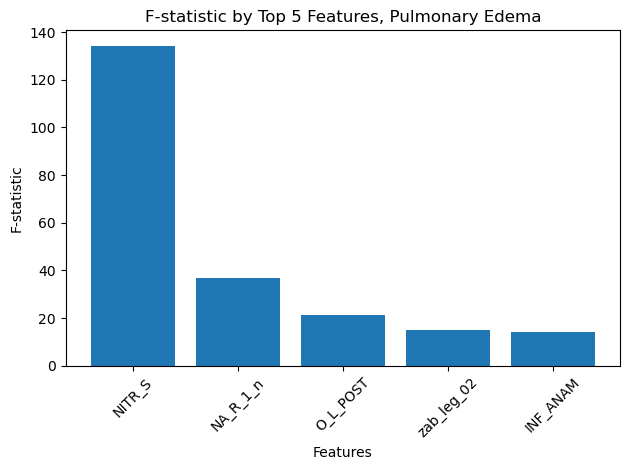

In [433]:
'''
f-tests for classification problems (linear correlations)
'''

from sklearn.feature_selection import f_classif, mutual_info_classif

X_oh_ord = X[np.concatenate([onehot_ftrs,ordinal_ftrs])] #only onehot and ordinal ftrs because no nans
X_oh_ord.fillna(-1, inplace=True)

f_stats, p_values = f_classif(X_oh_ord, y)
lin_corr = pd.Series(f_stats, index = X_oh_ord.columns).sort_values(ascending=False)

Xf = lin_corr.head(5).index
Yf = lin_corr.head(5).values
print(max(Yf))

plt.bar(Xf, Yf)
figsize = (4,3)
plt.title(f'F-statistic by Top 5 Features, Pulmonary Edema')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()

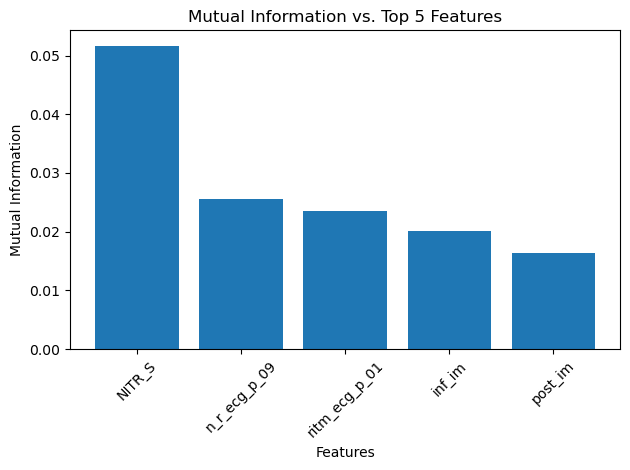

In [434]:
''' 
MI test for classification (non-linear correlations)
'''
mc = mutual_info_classif(X_oh_ord, y)
non_lin_corr = pd.Series(mc, X_oh_ord.columns).sort_values(ascending=False)

Xm = non_lin_corr.head(5).index
Ym = non_lin_corr.head(5).values

plt.bar(Xm, Ym)
figsize=(4,3)
plt.title(f'Mutual Information vs. Top 5 Features')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

**MODEL TESTING & CROSS VALIDATION**

LOGISTIC REGRESSION

In [435]:
''' 
Logistic regression cannot handle NaNs, so we must adjust for that.
'''

# 1. Find all columns that have NaNs and their ocurrence
X_nans_std = X[std_ftrs].isna().sum() #AST_BLOOD, ALT_BLOOD, ROE

X_nans_minmax = X[minmax_ftrs].isna().sum()

print(X_nans_std)
print(X_nans_minmax)

ALT_BLOOD    110
AST_BLOOD    111
K_BLOOD        0
L_BLOOD        0
NA_BLOOD       0
ROE           60
dtype: int64
AGE          0
S_AD_ORIT    0
D_AD_ORIT    0
dtype: int64


In [439]:
''' 
Find training/validation set with the best score.
'''
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(max_iter=300)

for fold, X_data in X_splits_prep.items():
    print(fold)

    # Dropping continuous columns with NaNs
    X_train = X_data['X_train_df'].drop(['std__AST_BLOOD', 'std__ALT_BLOOD', 'std__ROE'], axis=1)
    y_train = splits[fold]['y_train']

    model = LogReg.fit(X_train,y_train) 

    # Dropping continuous columns with NaNs
    X_val = X_data['X_val_df'].drop(['std__AST_BLOOD', 'std__ALT_BLOOD', 'std__ROE'], axis=1)
    y_val = splits[fold]['y_val']

    y_pred_val = model.predict_proba(X_val)

    score = model.score(X_val, y_val, sample_weight=None)

    print(score)

fold_0
0.813953488372093
fold_1
0.8662790697674418
fold_2
0.9005847953216374
fold_3
0.8538011695906432
fold_4
0.8421052631578947


In [ ]:
''' 
Test model with testing data using train data from fold_2.
'''
X_data = X_splits_prep['fold_2']
X_train = X_data['X_train_df'].drop(['std__AST_BLOOD', 'std__ALT_BLOOD', 'std__ROE'], axis=1)
y_train = splits['fold_2']['y_train']

X_test = X_data['X_test_df'].drop(['std__AST_BLOOD', 'std__ALT_BLOOD', 'std__ROE'], axis=1)
y_test = y_test

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score) #87.4% accurate

0.8744186046511628


GLOBAL FEATURE INTERPRETATION

In [455]:
features = X_train.columns
importances = abs(model.coef_).reshape(len(features),)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})


**MULTIPLE MODEL GRID CV (MODELS THAT CAN'T HANDLE NANS)**
- Logistic regression (Lasso/L1)
- Logistic regression (Ridge/L2)
- K-nearest neighbors
- Support Vector Classifier

In [ ]:
''' 
Preparing for splitting.
- X, y are already defined and cleaned
'''

# Removing continuous columns with NaNs
X_no_nans = X.drop(['AST_BLOOD', 'ALT_BLOOD', 'ROE'], axis=1)

# Categorical
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1))])

# MinMax 
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])

# Standard scaler 
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', std_transformer, std_ftrs),
        ('ohot', one_hot_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error



**INTERPRETABILITY**

**REMOVING FEATURES AND RETRYING**